<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0629onomatopea_sentence_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. オノマトペ単語を sentenceBERT で処理する

In [ ]:
%config InlineBackend.figure_format = 'retina'
try:
    import bit
except ImportError:
    !pip install ipynbname > /dev/null 2>&1
    !git clone https://github.com/ShinAsakawa/bit.git
import bit
isColab = bit.isColab
HOME = bit.HOME

if isColab:
    !pip install --upgrade xlrd
    !pip install --upgrade 'fugashi[ipadic]'
    !pip install --upgrade 'fugashi[unidic]'
    !python -m unidic download
    !pip install --upgrade ipadic
    !pip install --upgrade transformers
    !pip install --upgrade termcolor
    !pip install --upgrade jaconv    

In [ ]:
from transformers import BertJapaneseTokenizer, BertModel
import torch

class SentenceBertJapanese:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)

In [ ]:
model = SentenceBertJapanese("sonoisa/sentence-bert-base-ja-mean-tokens")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.


In [ ]:
# 2021/Jan 近藤先生からいただいたオノマトペ辞典のデータの読み込み
import os 
#'日本語オノマトペ辞典4500より.xls' は著作権の問題があり，公にできません。
# そのため Google Colab での解法，ローカルファイルよりアップロードしてください
if isColab:
    from google.colab import files
    uploaded = files.upload()  # ここで `日本語オノマトペ辞典4500より.xls` を指定してアップロードする
    data_dir = '.'
else:
    data_dir = os.path.join(HOME, 'study/2021ccap/notebooks')

import pandas as pd
import jaconv

onomatopea_excel = '2021-0325日本語オノマトペ辞典4500より.xls'
onmtp2761 = pd.read_excel(os.path.join(data_dir, onomatopea_excel), sheet_name='2761語')

#すべてカタカナ表記にしてデータとして利用する場合
#`日本語オノマトペ辞典4500` はすべてひらがな表記だが，一般にオノマトペはカタカナ表記されることが多いはず
#onomatopea = list(sorted(set([jaconv.hira2kata(o) for o in onmtp2761['オノマトペ']])))

# Mac と Windows の表記の相違を吸収
onomatopea = list(sorted(set([jaconv.normalize(o) for o in onmtp2761['オノマトペ']])))
print(f'データファイル名: {os.path.join(data_dir, onomatopea_excel)}\n',
      f'オノマトペ単語総数: len(onomatopea):{len(onomatopea)}')

データファイル名: /Users/_asakawa/study/2021ccap/notebooks/2021-0325日本語オノマトペ辞典4500より.xls
 オノマトペ単語総数: len(onomatopea):1741


In [ ]:
%%time
onomatopea_vectors = model.encode(onomatopea)

CPU times: user 59.2 s, sys: 808 ms, total: 60 s
Wall time: 58.9 s


## 1.1 意味が近いオノマトペをクラスタリング

In [ ]:
print(f'len(onomatopea):{len(onomatopea)}')
print(f'onomatopea_vectors.shape:{onomatopea_vectors.shape}')
#print(f'cluster_assignment.shape:{cluster_assignment.shape:}')

len(onomatopea):1741
onomatopea_vectors.shape:torch.Size([1741, 768])


In [ ]:
from sklearn.cluster import KMeans

num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(onomatopea_vectors)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for _id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(onomatopea[_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['あやふや', 'あわわ', 'あんあん', 'あんぐり', 'あーん', 'いがいが', 'いけつんつん', 'うえんうえん', 'うじゃうじゃ', 'うじょうじょ', 'うとうと', 'うわーん', 'えんえん', 'えーん', 'おんおん', 'かしゃん', 'かたかた', 'かたん', 'かたんかたん', 'かたんことん', 'かちゃかちゃ', 'かちゃり', 'かちゃん', 'かちん', 'かちんかちん', 'かちんこちん', 'かっちゃん', 'かっちんかっちん', 'かつん', 'かりん', 'かん', 'かんから', 'かんかん', 'かんらかんら', 'かーん', 'がくがく', 'がくん', 'がくんがくん', 'がちゃり', 'がちゃん', 'がちり', 'がちん', 'がちんがちん', 'がっしゃん', 'がっちゃん', 'がっちんがっちん', 'がっぽり', 'がばちょ', 'がん', 'がんがらがん', 'がんがん', 'がーん', 'きゃんきゃん', 'きんきら', 'きんきらきん', 'きんきん', 'きんきんきらきら', 'ぎゃはは', 'ぎゃふん', 'ぎゃんぎゃん', 'ぎんぎらぎん', 'ぎんぎん', 'ぎんぎんぎらぎら', 'ぎーとんぎーとん', 'くにゃくにゃ', 'くにゃり', 'ぐじょぐじょ', 'ぐでんぐでん', 'ぐんぐん', 'ぐんにゃり', 'こくん', 'こちゃこちゃ', 'こちり', 'こちん', 'こちんこちん', 'こつん', 'ことん', 'ことんことん', 'こほんこほん', 'こん', 'こんがり', 'こんこん', 'こんもり', 'こーん', 'ごくんごくん', 'ごじゃごじゃ', 'ごちゃくちゃ', 'ごちん', 'ごとん', 'ごとんごとん', 'さんさん', 'ざんざん', 'しなっ', 'しゃん', 'しゃんしゃん', 'しゅん', 'しゅんしゅん', 'しん', 'しんなり', 'しんねり', 'しんみり', 'じたんばたん', 'じゃぶん', 'じゃぼん', 'じゃらん', 'じゃらんじゃらん', 'じゃん', 'じゃんじゃか', 'じゃんじゃん', 'じん', 'じんじん', 'じんわり', 'ずきん', 'ずきんずきん', 'ずどん', 'せんせん', 

## 1.2 意味が近いオノマトペを検索

In [ ]:
import scipy.spatial

queries = onomatopea[:10]
query_embeddings = model.encode(queries).numpy()

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], onomatopea_vectors, metric="cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("=" * 78)
    print("Query:", query)
    print("Top 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(onomatopea[idx].strip(), "(Score: %.4f)" % (distance / 2))

Query: あくせく
Top 5 most similar sentences in corpus:
あくせく (Score: 0.0000)
さめざめ (Score: 0.0625)
うっとり (Score: 0.0688)
てかてか (Score: 0.0699)
うんざり (Score: 0.0745)
Query: あたふた
Top 5 most similar sentences in corpus:
あたふた (Score: 0.0000)
たぷたぷ (Score: 0.0924)
おたおた (Score: 0.0988)
すたこら (Score: 0.1086)
たー (Score: 0.1130)
Query: あっけらかん
Top 5 most similar sentences in corpus:
あっけらかん (Score: 0.0000)
てかてか (Score: 0.0738)
きっかり (Score: 0.0864)
しこしこ (Score: 0.0897)
あくせく (Score: 0.1004)
Query: あっはっは
Top 5 most similar sentences in corpus:
あっはっは (Score: 0.0000)
はった (Score: 0.0387)
はっ (Score: 0.0410)
はっし (Score: 0.0567)
はっはっ (Score: 0.0662)
Query: あっぱらぱー
Top 5 most similar sentences in corpus:
あっぱらぱー (Score: 0.0000)
ぱさっ (Score: 0.0649)
ぱさぱさ (Score: 0.0703)
ぱしぱし (Score: 0.0706)
ぱしっ (Score: 0.0734)
Query: あっぷあっぷ
Top 5 most similar sentences in corpus:
あっぷあっぷ (Score: 0.0000)
ぷっぷっ (Score: 0.1035)
ぷかっ (Score: 0.1088)
あっぱらぱー (Score: 0.1157)
ぷっつ (Score: 0.1172)
Query: あはあは
Top 5 most similar sentences in corpus:


## 1.3 オノマトペの可視化 tSNE による散布図

In [ ]:
#!cat ccap/__init__.py
from ccap import tsne

X = tsne.tsne(onomatopea_vectors.clone().numpy())

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  1741 ...
Computing P-values for point  500  of  1741 ...
Computing P-values for point  1000  of  1741 ...
Computing P-values for point  1500  of  1741 ...
Mean value of sigma:  5.559793018161326
Iteration  250 : error is  0.8897947757161339
Iteration  500 : error is  0.7909912878780277
Iteration  750 : error is  0.7747143144743237
Iteration  1000 : error is  0.7687974439997878


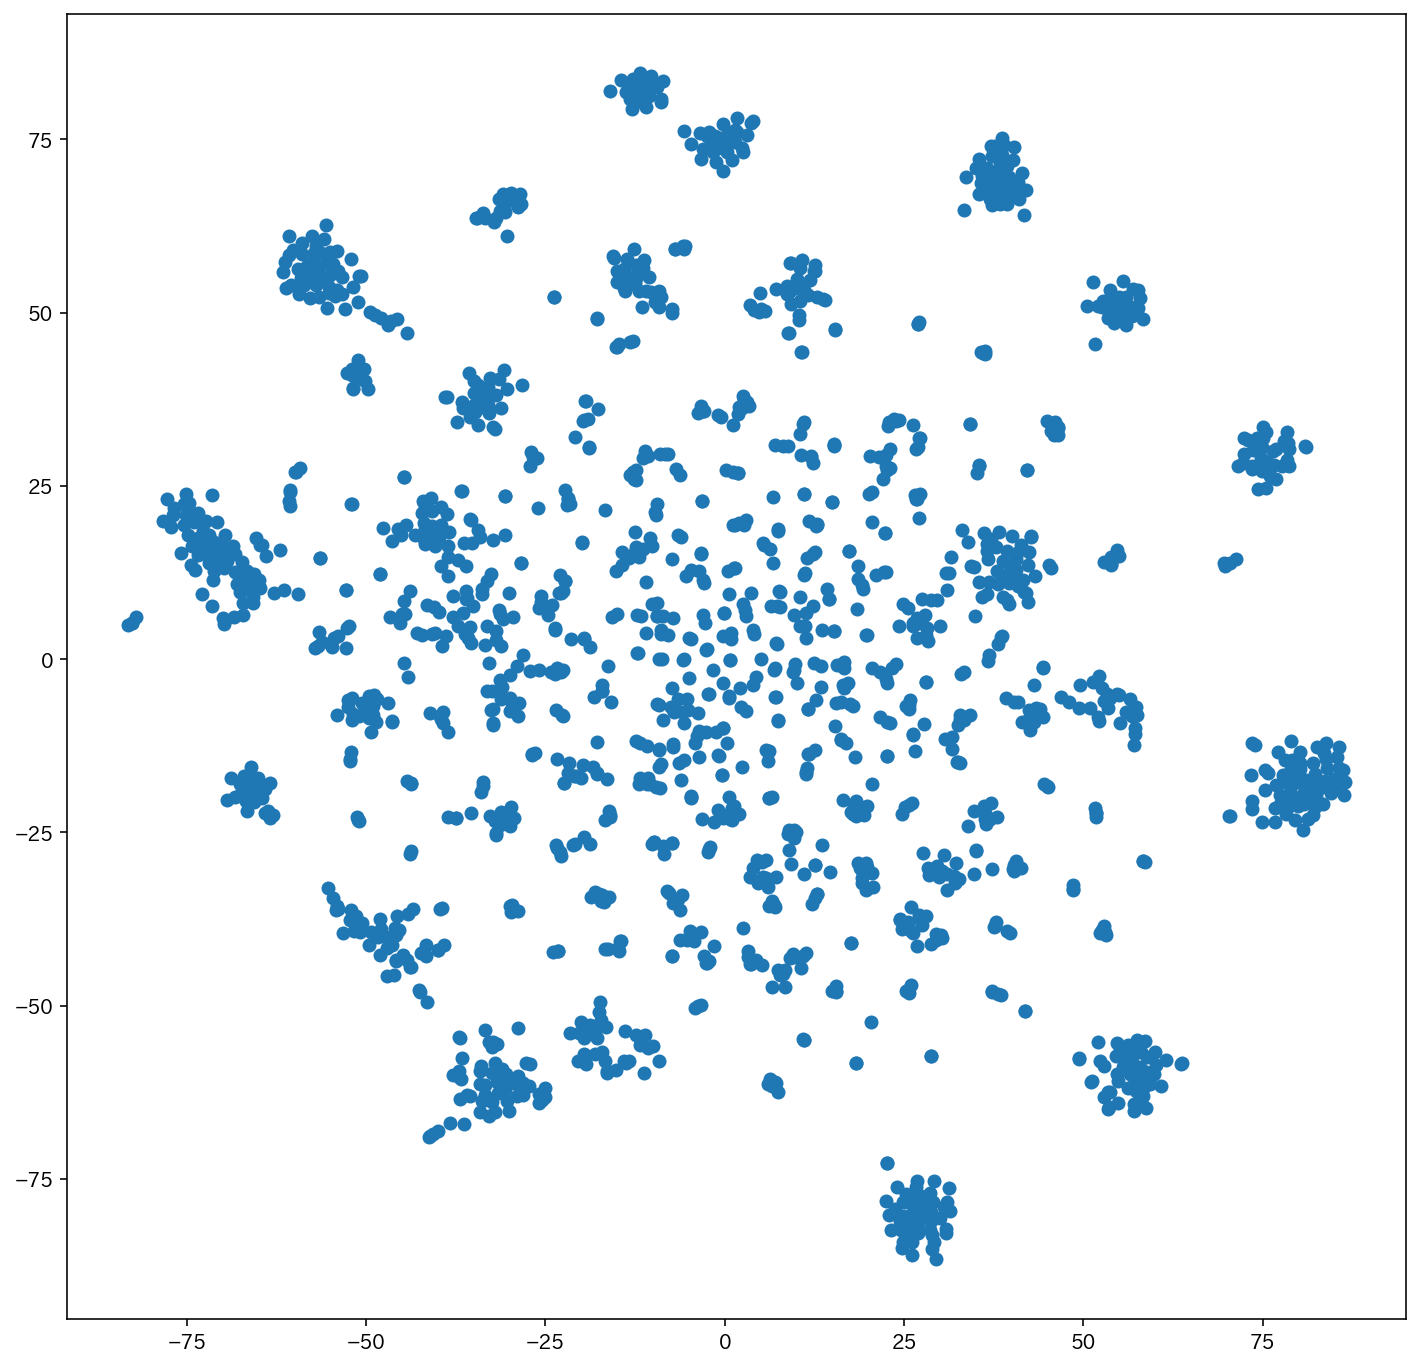

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.scatter(X[:,0], X[:,1])

# 2. `onomatope11 (1).xlsx` を用いたオノマトペ説明文の BERT 化

In [ ]:
if isColab:
    # '2022_0531onomatope11.xlsx' または onomatope11(1).xlsx をアップロードする
    from google.colab import files
    uploaded = files.upload()

In [ ]:
import pandas
# fname = 'onomatope11 (1).xlsx'
# 上の若干の入力ミスと思われる部分を修正した。オリジナルは onomatope11(1).xlsx
fname = '2022_0531onomatope11.xlsx'

if isColab:
    df = pandas.read_excel(fname, sheet_name='onomatope11')
else:
    df = pandas.read_excel(os.path.join(HOME, 'study/2022kondo_project', fname), sheet_name='onomatope11')

X = df[['bunn', 'onomatope']].values.tolist()
onomatopea_sentences = [jaconv.normalize(str(line[0]))+'、'+jaconv.normalize(str(line[1])) for line in X]

In [ ]:
%%time
# 全オノマトペをベクトル化
onomatopea_vectors = model.encode(onomatopea_sentences)

CPU times: user 3min 12s, sys: 2.57 s, total: 3min 15s
Wall time: 3min 9s


## 2.1 意味が近いオノマトペ文をクラスタリング

In [ ]:
print(f'len(onomatopea_sentences):{len(onomatopea_sentences)}')
print(f'onomatopea_vectors.shape:{onomatopea_vectors.shape}')
print(f'cluster_assignment.shape:{cluster_assignment.shape:}')

len(onomatopea_sentences):2469
onomatopea_vectors.shape:torch.Size([2469, 768])
cluster_assignment.shape:(2469,)


In [ ]:
from sklearn.cluster import KMeans

num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(onomatopea_vectors)
cluster_assignment = clustering_model.labels_
print(f'オノマトペ総数(cluster_assignment.shape):{cluster_assignment.shape}')
print(f'onomatopea_vectors.shape:{onomatopea_vectors.shape}')


clustered_sentences = [[] for i in range(num_clusters)]
not_clustered = []
for _id, cluster_id in enumerate(cluster_assignment):
    if cluster_id >= num_clusters:
        #辞書に存在しない単語を登録してスキップする
        not_clustered.append((_id, cluster_id, onomatopea_sentences[_id]))
        continue
    clustered_sentences[cluster_id].append(onomatopea_sentences[_id])

print(f'not_clustered:{not_clustered}')    
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    #print("")

オノマトペ総数(cluster_assignment.shape):(2469,)
onomatopea_vectors.shape:torch.Size([2469, 768])
not_clustered:[]
Cluster  1
['粉雪などがごく軽いようすで、はらはら', '微風が木の葉の音を立てて、さやさや', 'すきま風や微風を体に感じて、すーっ', '風に布などが軽くあおられて、ぱたぱた', 'あたたかさに包まれなどんで、ほわっ', '少量の水が細く勢いよく飛び、ちゅっ', '少量の水が細く勢いよく飛び、ぴゅっ', '水が軽く砕けたり飛び散って、ぱしゃっ', '水が軽やかに流れ続けて、しゃーしゃー', '水が軽やかにわき出て、ころころ', '水が軽く波立って、ちゃぷちゃぷ', '液体が小さく泡立って、こぽこぽ', '煙だけ出してくすぶって、ぷすぷす', '煙だけ出してくすぶって、ぶすぶす', '水がゆれて軽い音をたてて、とぷんとぷん', '砂などを踏んで歩いて、そくそく', '軽快に走って、たったかたったか', 'せかされるように小走りで、 せかせか', '軽い音をたてながら歩いて、 しゃらりしゃらり', 'やっとのことで歩いて、えっちらおっちら', '足早に歩いて、ぴたぴた', '小走りで、ととと', '足早に調子をとって小またで、とっとっ', '足早に調子をとって小またで、とっとことっとこ', '子どもが小またで小差ぎみに、とことこ', '体の一部が小さくひきつって、びくびく', '体の一部が小さくひきつって、ぴくぴく', '少しずつこまかくふるえて、ぴこぴこ', '一瞬ふるえ動いて、ぴりっ', '小さく瞬間的に振動して、ぷるっ', '軽くこまかくふるえ動いて、ぷるぷる', '軽くこまかくふるえ動いて、ふるふる', 'かたいものをひと口かじって、がりっ', 'かたいものをひと口かじって、がりり', 'かたいものを一度歯切れよく、かりっ', 'かたいものを一度歯切れよく、かりり', 'かたいものを一度歯切れよく、かりん', 'かたいものを軽くかみ砕き、かりかり', 'ものが小さく目に見えて、ぽつん?', 'ものが小さく目に見えて、ぽつっ', '大口を盛んに開け閉めして、ぱくりぱくり', '大口を盛んに開け閉めして、ばくりばくり', '大口を盛んに開

In [ ]:
#print(len(cluster_assignment))
#type(cluster_assignment)
#cluster_assignment.min()
for i in enumerate(cluster_assignment):
    print(i)
len(clustered_sentences[0])

## 2.2 意味が近いオノマトペ文を検索

In [ ]:
import scipy.spatial

queries = onomatopea_sentences[:10]
query_embeddings = model.encode(queries).numpy()

closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], onomatopea_vectors, metric="cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("=" * 78)
    print("Query:", query)
    print("Top 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        print(onomatopea_sentences[idx].strip(), "(Score: %.4f)" % (distance / 2))

Query: 日が射したり光がともって、ぽっ
Top 5 most similar sentences in corpus:
日が射したり光がともって、ぽっ (Score: 0.0000)
日ざしがあってあたたかく、ぽかりぽかり (Score: 0.1239)
表面がぬれてやわらかく光り、ぬめぬめ (Score: 0.1309)
表面がぬれてにぶく光って、てらてら (Score: 0.1374)
太陽が焼けつくように照り、じりじり (Score: 0.1424)
Query: あたたかい日ざしが差しこみ、ぽかぽか
Top 5 most similar sentences in corpus:
あたたかい日ざしが差しこみ、ぽかぽか (Score: 0.0000)
日ざしがあってあたたかく、ぽかりぽかり (Score: 0.0476)
日ざしがおだやかで、おっとり (Score: 0.0969)
春の日ざしがあたたかく、うらら (Score: 0.1203)
日ざしがいっぱいに差しこみ、さんさん(燦燦) (Score: 0.1293)
Query: 水や日ざしが満ち満ちて、なんなん
Top 5 most similar sentences in corpus:
水や日ざしが満ち満ちて、なんなん (Score: 0.0000)
日ざしがおだやかで、おっとり (Score: 0.1425)
気持ちわるく絶えず水分が、じくじく (Score: 0.1465)
すっかり日が暮れて、とっぷり (Score: 0.1482)
表面がぬれてやわらかく光り、ぬめぬめ (Score: 0.1506)
Query: すっかり日が暮れて、とっぷり
Top 5 most similar sentences in corpus:
すっかり日が暮れて、とっぷり (Score: 0.0000)
日ざしがおだやかで、おっとり (Score: 0.1256)
卑屈に/照れて/得意になり、へっへっ (Score: 0.1408)
卑屈に/照れて/得意になり、へへへ (Score: 0.1414)
水や日ざしが満ち満ちて、なんなん (Score: 0.1482)
Query: 日光の照り輝いて、てかてか
Top 5 most similar sentences in corpus:
日光の照り輝いて、てかて

## 1.3 オノマトペの可視化 tSNE による散布図

In [ ]:
#!cat ccap/__init__.py
from ccap import tsne

X = tsne.tsne(onomatopea_vectors.clone().numpy())

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  2469 ...
Computing P-values for point  500  of  2469 ...
Computing P-values for point  1000  of  2469 ...
Computing P-values for point  1500  of  2469 ...
Computing P-values for point  2000  of  2469 ...
Mean value of sigma:  5.135997800727117
Iteration  250 : error is  1.3801800416024712
Iteration  500 : error is  1.1823220769860487
Iteration  750 : error is  1.142341826627212
Iteration  1000 : error is  1.1284543689265705


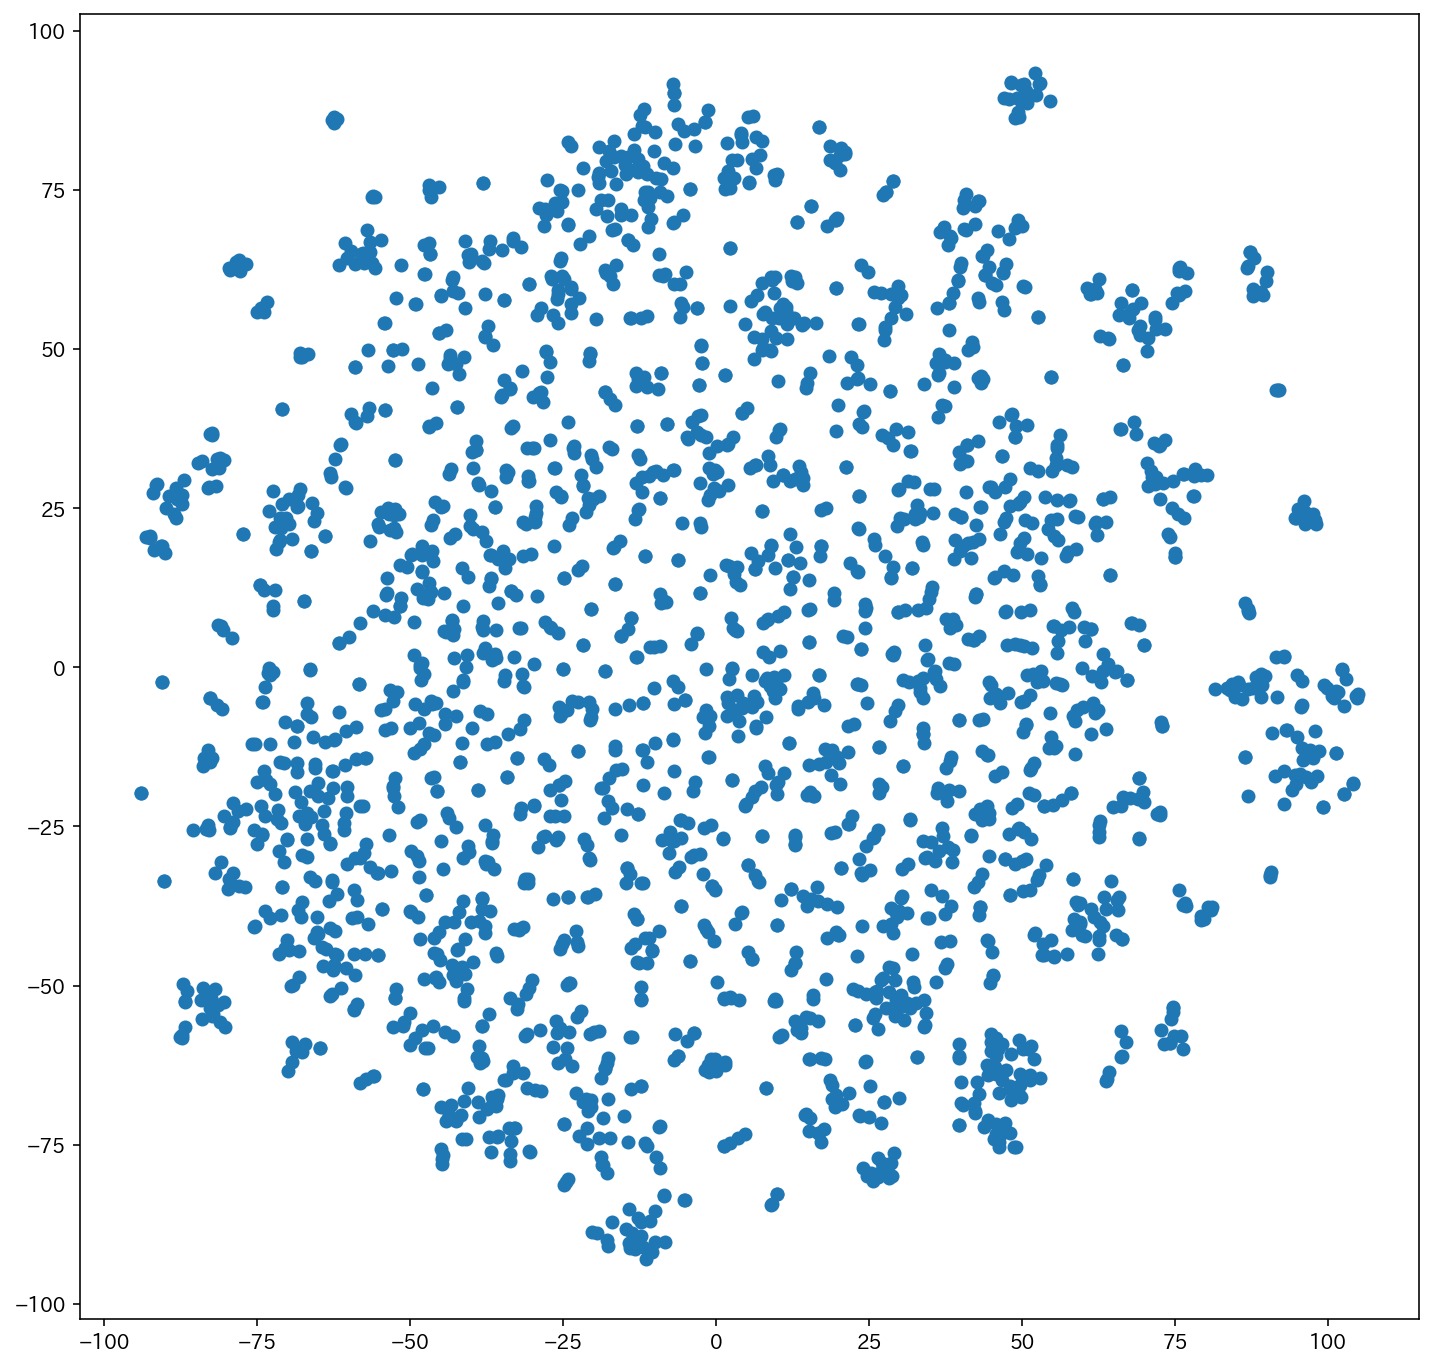

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.scatter(X[:,0], X[:,1])

In [ ]:
onomatopea_sentences[:10]

['日が射したり光がともって、ぽっ',
 'あたたかい日ざしが差しこみ、ぽかぽか',
 '水や日ざしが満ち満ちて、なんなん',
 'すっかり日が暮れて、とっぷり',
 '日光の照り輝いて、てかてか',
 '雲ひとつなく晴れ上がって、すかっ',
 '太陽が焼けつくように照り、じりじり',
 '日ざしがいっぱいに差しこみ、さんさん(燦燦)',
 '曇っていた空が明るく晴れて、けろり',
 '真夏の太陽が強く照りつけて、ぎらぎら']

# ここから下は以前のコードなので，無視してください。

In [ ]:
import torch
#from torch.nn import functional as F
from transformers import BertJapaneseTokenizer
from transformers import BertForNextSentencePrediction
#from transformers import BertForMaskedLM

model_name_ja = 'cl-tohoku/bert-base-japanese'
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_ja)
model_nsp = BertForNextSentencePrediction.from_pretrained(model_name_ja)

from transformers import BertForSequenceClassification
classify_model = BertForSequenceClassification.from_pretrained(model_name_ja, num_labels=9)
print(classify_model.classifier)
# Linear(in_features=768, out_features=9, bias=True)

# `from_pretrained` 時に `num_labels` を指定する。
# これにより，任意のクラス数の分類器にできる。
# デフォルトでは 2 クラス分類器
# tokenizerと同様キャッシュダウンロードになる。
# なので保存したい場合は下記のようにする。
model_saved_fname = '2022_0607bert_classify_model.pt'
classify_model.save_pretrained(model_saved_fname) # save
classify_model2 = BertForSequenceClassification.from_pretrained(model_saved_fname) # load

In [ ]:
import torch
from torch.nn import functional as F
from transformers import BertJapaneseTokenizer
#from transformers import BertForMaskedLM
from transformers import BertForNextSentencePrediction

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')
model_nsp = BertForNextSentencePrediction.from_pretrained('cl-tohoku/bert-base-japanese')

# # GPU が利用可能であれば利用する
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_nsp.to(device)

prompt = "行く川の流れ絶えずして"
next_sentence = "しかも元の水にあらず。"
next_sentence = "吾輩は猫である。"

encoding = tokenizer.encode_plus(prompt, next_sentence, return_tensors='pt')
outputs = model_nsp(**encoding)[0]
softmax = F.softmax(outputs, dim = 1)
print(softmax)

In [ ]:
import torch
from torch.nn import functional as F

from transformers import BertJapaneseTokenizer
from transformers import BertForMaskedLM

#model_name = 'cl-tohoku/bert-base-japanese'      # 東北大学乾研による 日本語 BERT 実装
model_name = 'cl-tohoku/bert-base-japanese-v2'

tknz = BertJapaneseTokenizer.from_pretrained(model_name)
mlm  = BertForMaskedLM.from_pretrained(model_name, return_dict=True)

# # GPU が利用可能であれば利用する
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mlm.to(device)

text = "吾輩は猫である。" + tokenizer.mask_token + "はまだない。"
_input = tknz.encode_plus(text, return_tensors="pt")
mask_index = torch.where(_input["input_ids"][0] == tknz.mask_token_id)
output = mlm(**_input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
topN = 10
tokens = torch.topk(mask_word, topN, dim=1)[1][0]
for token in tokens:
    word = tknz.convert_ids_to_tokens(token.detach().item())
    sent_pred = text.replace(tknz.mask_token, word)
    print(sent_pred)


In [ ]:
# 2021/Jan 近藤先生からいただいたオノマトペ辞典のデータの読み込み
#'日本語オノマトペ辞典4500より.xls' は著作権の問題があり，公にできません。
# そのため Google Colab での解法，ローカルファイルよりアップロードしてください
import os
import pandas as pd
import jaconv

if isColab:
    from google.colab import files
    uploaded = files.upload()  # ここで `日本語オノマトペ辞典4500より.xls` を指定してアップロードする
    data_dir = '.'
else:
    data_dir = os.path.join(HOME, 'study/2021ccap/notebooks')


onomatopea_excel = '2021-0325日本語オノマトペ辞典4500より.xls'
onmtp2761 = pd.read_excel(os.path.join(data_dir, onomatopea_excel), sheet_name='2761語')

#すべてカタカナ表記にしてデータとして利用する場合
#`日本語オノマトペ辞典4500` はすべてひらがな表記だが，一般にオノマトペはカタカナ表記されることが多いはず
#onomatopea = list(sorted(set([jaconv.hira2kata(o) for o in onmtp2761['オノマトペ']])))

# Mac と Windows の表記の相違を吸収
onomatopea = list(sorted(set([jaconv.normalize(o) for o in onmtp2761['オノマトペ']])))
print(f'データファイル名: {os.path.join(data_dir, onomatopea_excel)}\n',
      f'オノマトペ単語総数: len(onomatopea):{len(onomatopea)}')

# トークナイザ の修正，実際には onomatopea 単語リストを引数に指定して `add_tokens()` を呼び出すだけ
# ただし，語彙数 tknz.vocab は変更されない。追加された語彙，本コードの場合はオノマトペは，
# `tknz.added_tokens_encoder` と `tknz1.added_tokens_decoder` に反映されているためである
num_added = tknz.add_tokens(onomatopea)
print(f'追加されたトークン数:{num_added}/オノマトペ数:{len(onomatopea)}') 
#model_onmt.resize_token_embeddings(len(tknz))
#model_orig.resize_token_embeddings(len(tknz))
classify_model.resize_token_embeddings(len(tknz))
classify_model2.resize_token_embeddings(len(tknz))

print(f' len(tknz):{len(tknz)}\n', 
      f'len(tknz.vocab):{len(tknz.vocab)}\n',  # 一見すると，この数字からオノマトペが追加されていないように見える。
      f'tknz.vocab_size:{tknz.vocab_size}')    # 駄菓子菓子，下で見るように，正しく動作しているように見受けられる

print('# 確認用')
for w in onomatopea[-5:]:
    idx = tknz.convert_tokens_to_ids(w)
    w_ = tknz.convert_ids_to_tokens(idx)
    print(f'単語:{w}(id:{idx}) -> token:{w_}')

In [ ]:
import pandas
import jaconv

df = pandas.read_excel('../2022_0531onomatope11.xlsx')
# 若干の入力ミスと思われる部分を修正した。オリジナルは onomatope11(1).xlsx
bunn = df['bunn'].to_list()
onmtp = df['onomatope'].to_list()
_bunn = [jaconv.normalize(line, 'NFKC') for line in bunn]
_onmtp = [jaconv.normalize(line, 'NFKC') for line in onmtp]
bunn = _bunn
onmtp = _onmtp

ono2sen = {}
sen2ono = {}
for __bunn, __onmtp in zip(bunn, onmtp):
    if not __onmtp in ono2sen:
        ono2sen[__onmtp] = []
    ono2sen[__onmtp].append(__bunn)
    
    if not __bunn in sen2ono:
        sen2ono[__bunn] = []
    sen2ono[__bunn].append(__onmtp)

    
max_cand = 0
for k, v in ono2sen.items():
    n = len(ono2sen[k])
    if n > max_cand:
        max_cand = n
        max_ono = k

print(max_cand, max_ono)
print(ono2sen[max_ono])


max_cand = 0
for k, v in sen2ono.items():
    n = len(sen2ono[k])
    if n > max_cand:
        max_cand = n
        max_sen = k
print(max_cand, max_sen)
print(sen2ono[max_sen])

onomatopea_ids = [tknz.convert_tokens_to_ids(w) for w in onomatopea]
onomatopea == [tknz.convert_ids_to_tokens(tknz.convert_tokens_to_ids(w)) for w in onomatopea]
print(len(onomatopea_ids))

In [ ]:
from transformers import BertModel

class Bert_Model(nn.Module):
    def __init__(self, class):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(self.bert.config.hidden_size, classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input, attention_mask):
        _, output = self.bert(input, attention_mask = attention_mask)
        out = self.sigmoid(self.out(output))
        return out

In [ ]:
#help(tokenizer.decode)
#tokenizer.convert_ids_to_tokens(1803)
print(type(token.detach().item()))


## Hugging Face Transformers library の BERTの使い方

Hugging Face transformers library から BERT を使用する方法 4 つの重要な課題

この記事では Hugging Face Transformer ライブラリを使用した BERT を 4 つの重要な課題に使用する方法を紹介する。 また BERT が解決するように設計された標準的な課題だけでなく，あなたが使いたいと思うあらゆる課題のために BERT を設定する方法を紹介する。

この記事は 2021 年 1 月に書かれたものなので，以前の/将来のバージョンの Hugging Face ライブラリは少し違っていて，この記事のコードは必ずしも動作しないかもしれないことに注意。

## 1. BERT トークナイザー

BERT Tokenizer は BERT で動作するトークナイザである。
このトークナイザは，あらゆるタイプのトークン化課題のための多くの機能性を持っている。
このコードの行を使用してトークナイザをダウンロードすることができる。

In [ ]:
tknz = BertJapaneseTokenizer.from_pretrained(model_ja_name)

異なるタイプのモデルごとに異なるトークナイザをダウンロードする必要はない。
Hugging face が提供する様々な BERT モデル全てに同じトークナイザを使用することができる。

一般的に行っているトークン化の方法は次のとおり：

In [ ]:
text = '吾輩は猫である'
encoding = tknz.encode_plus(text, 
                            add_special_tokens = True,
                            truncation = True, 
                            padding = 'longest',
                            #padding = 'do_not_pad',
                            #padding = 'max_length',
                            return_attention_mask = True, 
                            return_tensors = "pt")

- BERT は 一度に 512 個のトークンしか入力として受け入れる/受け取ることができないため truncation パラメータを True に指定する必要がある。 
- `add_special_tokens` パラメータは BERT が開始，終了，[SEP] および [CLS] トークンのようなトークンを追加するため
- `return_tensors=“pt”` は トークン化器が PyTorch テンソルを返すため。もしそうしたくない場合 (リストを返したい場合など) は，このパラメータを外すとリストを返す。

以下のコードでは，上に挙げたパラメータをすべて追加していないのがわかるが，これは主に実際のプロジェクトでテキストをトークン化するわけではないので，必要ないためである。 実際の機械学習/自然言語処理プロジェクトでは，これらのパラメータ，特に切り捨てとパディングを追加する必要がある。

- `tokenizer.encode_plus()` は特に、単なる値のリストではなく，値の辞書を返す。
- `tokenizer.encode_plus()` は `attention_masks` やトークン型の ID など様々な情報を返すことができるので，全てを辞書形式で返し，エンコードの特定の部分を取得したい場合は，このようにすることができる。



In [ ]:
print(encoding)
print(encoding['input_ids'])
print(encoding['input_ids'][0])

inputs = encoding['input_ids'][0]
attention_mask = encoding['attention_mask'][0]


さらにトークナイザーは異なる値の辞書を返すので，上記のようにこれらの値を見つけ，これらを個別にモデルに渡す代わりに，次のようにエンコーディング全体を渡すことができます。

In [ ]:
outputs = model(**encoding)
print(outputs)

もうひとつトークナイザについて知っておくべき非常に重要なことは，必要に応じて特定のトークンを取得するように指定できることである。
たとえばマスク化言語のモデリングをするときに，デコードする場所にマスクを挿入したい場合，次のようにマスク・トークンを取得することができる。

In [ ]:
print(tknz.mask_token)

これを入力テキストと連結することで簡単に入力に挿入できる。

また [SEP] トークンのような他の多くのトークンも同じ方法で取り出すことができる。

通常 `tokenizer.encode_plus()` 関数を使って入力のトークン化を行うが，他にもトークン化に使える関数がある。
この `tokenizer.encode()` は入力のトークン化を行う。
以下はその例である:

In [ ]:
#encoding = tokenizer.encode(text, return_tensors = "pt")
encodings = tknz.encode(text, return_tensors='pt')
print(encodings)


`tokenizer.encode_plus()` と `tokenizer.encode()` の主な違いは `tokenizer.encode_plus()` がより多くの情報を返すということである。 

- `tokenize.encode_plus()` は，実際の入力 ID，アテンションマスク，トークンタイプ の ID を返し，これらをすべて辞書に格納して返す。
- `tokenizer.encode()` は入力 ID のみを返し，パラメータ return_tensors = "pt" に従ってリストまたはテンソルとしてこれを返す。

In [ ]:
print(f'tknz(text):{tknz(text)}')
print(f'tknz.encode_plus(text):{tknz.encode_plus(text)}')
print(f'tknz.encode(text):{tknz.encode(text)}')
print(tknz.special_tokens_map)

## 2. マスク化言語モデル

マスク化言語モデルとは，文中のマスクされたトークンを解読する課題である。
簡単に言うと空白を埋める作業である。

単にマスクトークンの置き換えに最適な候補語を取るのではなくマスクトークンの置き換え候補語の上位 10 個を取る方法を紹介する。

In [ ]:
from transformers import BertJapaneseTokenizer
from transformers import BertForMaskedLM
from torch.nn import functional as F
import torch

model_ja_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tknz = BertJapaneseTokenizer.from_pretrained(model_ja_name)
model2 = BertForMaskedLM.from_pretrained(model_ja_name, return_dict = True)

text = "太陽が" + tknz.mask_token + "と輝く"
inputs = tknz.encode_plus(text, return_tensors = "pt")
mask_index = torch.where(inputs["input_ids"][0] == tknz.mask_token_id)
outputs = model2(**inputs)
logits = outputs.logits
softmax = F.softmax(logits, dim=-1)
mask_word = softmax[0, mask_index, :]
top10 = torch.topk(mask_word, 10, dim=1)[1][0]

for i, token in enumerate(top10):
    wrd = tknz.convert_ids_to_tokens([token])
    sentence_replaced = text.replace(tknz.mask_token, wrd[0])
    print(f'{i+1:2d}', sentence_replaced)

Hugging Face は事前に学習されたモデルを持つ課題については，その特定のモデルをダウンロード/インポートする必要があるように設定されている。
この場合，私たちは Bert For Masked Language Modeling モデルをダウンロードしなければなりませんが，トークナイザは前節で述べたように，すべての異なるモデルに対して同じものである。

- マスク言語モデリングは，マスクトークンを任意の位置に挿入し，その位置に入る最適な単語候補を予測することで機能する。
- マスクトークンは，上記のように，入力の希望する位置に連結して挿入すればよい。
- Bert Model for Masked Language Modeling は，その単語を置き換える最適な単語/トークンを語彙として予測する。
- logits は BERT の出力にソフトマックス活性化関数が適用される前の BERT モデルの出力である。
- ロジットを取得するためには，モデルを初期化するときにパラメータで `return_dict = True` を指定する必要があり，そうしないと上記のコードはコンパイルエラーになる。
- BERT Model に入力エンコーディングを渡した後，テンソルを返す 
- `output.logits` を指定するだけで `logits` を得ることができ，この後ようやく `logits` にソフトマックス活性化関数を適用することができる。 
- BERT の出力にソフトマックスを適用することで BERT の語彙の各単語の確率分布を得ることができる。
- より高い確率値を持つ単語はマスクトークンのより良い置換候補となる。
- マスクトークンを置き換えるための BERT の語彙内のすべての単語のソフトマックス値のテンソルを取得するために `torch.where()` を使用して取得したマスクトークンのインデックスを指定することができる。
- この例ではマスクトークンの置換候補単語の上位 10 個を取得しているので (パラメータを適宜調整すれば 10 個以上取得できる)，与えられたテンソル中の上位 $k$ 個の値を取得できる
- `torch.topk()` 関数を使い，その上位 $k$ 個の値を含むテンソルを返している。
- この後はテンソルを繰り返し処理し，文中のマスクトークンを候補トークンに置き換えるだけなので，比較的簡単な処理となる。

In [ ]:
newsents = ['夏の暑さが肌にじりじり感じる',
            '真夏の太陽がさんさんと照り付ける',
            '勢いよく雨がざーっと降る',
            'ろうそくの火が消えそうにゆらゆら灯る',
            '砂糖がこぼれてさらさら落ちる',
            '水が沸騰してごぽごぽ沸く',
            'お風呂でぬくぬくと温まる',
            'どんぶりに汁をだくだくと注ぐ',
            '日が照りぽかぽかと心地がよい',
            'クーラーからひんやりと風が吹く',
            '髪の毛がちりちりと燃える',
           ]

_newsents = ['夏の暑さが肌に[MASK]感じる。',
             '真夏の太陽が[MASK]と照り付ける。',
             '勢いよく雨が[MASK]と降る。',
             'ろうそくの火が消えそうに[MASK]灯る。',
             '砂糖がこぼれて[MASK]落ちる。',
             '水が沸騰して[MASK]沸く。',
             'お風呂で[MASK]と温まる。',
             'どんぶりに汁を[MASK]と注ぐ。',
             '日が照り[MASK]と心地がよい。',
             'クーラーから[MASK]と風が吹く。',
             '髪の毛が[MASK]と燃える。',
             'お酒に酔ってちどり足で[MASK]歩く。',
             '犬が顔を[MASK]舐める。',
             '風邪で咳が[MASK]出る',
             'けがをした子供が[MASK]と泣く',
             'ふくれっ面で[MASK]怒る',
             '悲しいことを思い出して、[MASK]する',
             '昼寝や休暇を取って、[MASK]する',
             'スポーツ選手のような[MASK]とした体だ',
             '物事が順調にいき調子よく[MASK]進む',
             '聞こえずらい小声で[MASK]話す',
             '水の中を平泳ぎで[MASK]進む',
             '翼を大きく[MASK]と広げる',
             '腕を回して肩を[MASK]と音を鳴らす',
             '地震が起きて建物が[MASK]と揺れる',
             '包丁で指を[MASK]と切る',
             '皿を擦り[MASK]と鳴らす',
             '電車が音を鳴らし[MASK]と走る',
             '花が枯れてしまい[MASK]する',
             '雑巾を[MASK]と絞る',
             '探偵が見つからないように[MASK]動き回る',
             '分散してみんな[MASK]に進む',
             '宝石を磨いてきれいに[MASK]光る',
             '髭が中途半端に生えて[MASK]した肌ざわりだ',
             '頭が割れるように[MASK]痛む', 
             '花火が音をたて打ち上がり[MASK]と爆ぜる',
             '魚が打ちあがり勢いよく[MASK]動く', 
             '揚げ物が軽快に[MASK]と揚がる',
             '突然空が雨雲に代わり雨が[MASK]と降り出した。',
             '風が通り抜け音を立てて[MASK]と鳴る',
             '人が小走りで道の上を[MASK]歩く',
             '祭りで和太鼓を[MASK]叩く',
             '虫がすばやく目の前を[MASK]と飛ぶ',
             '相撲取りがしりもちを[MASK]とつく',
             '友達に悪口を言われて[MASK]する',
             '急に雨が降り[MASK]と服が濡れる',
             '丸々太ったあざらしが坂を[MASK]転がる',
             '寝起きで寝癖がつき髪が[MASK]している',
             '驚いて口を[MASK]と大きく開け驚く',
             'ゴミ箱の中身を[MASK]音を立て漁る',
             '蛍光灯が切れかけて[MASK]と点滅する',
             '木が鈍く音をたてて[MASK]と倒れる',
             '硬そうなとても大きな角ばった[MASK]とした岩',
             'とても滑らかな光沢のある水晶が[MASK]と輝いている',
             '煎餅をたべ食べかすが[MASK]と崩れ落ちる',
             '熱い鉄板に水てきが落ちて[MASK]と蒸発する',
             '上司にしつこく怒られ[MASK]と説教される',
             '人に聞かれたくない噂話を友達と小さな声で[MASK]と話す',
             '街中でお祭りがあり人が集まり[MASK]と騒がしい',
             '何もすることがなく[MASK]と街中を歩く',
             '温泉の中は湯気が立ち込めて[MASK]と霧がかる'
            ]

for i, text in enumerate(_newsents):
    print(f'{i:3d} text:{text}')
    inputs = tknz.encode_plus(text, return_tensors = "pt")
    mask_index = torch.where(inputs['input_ids'][0] == tknz.mask_token_id)
    outputs = model2(**inputs)
    logits = outputs.logits
    softmax = F.softmax(logits, dim=-1)
    mask_word = softmax[0, mask_index, :]
    top10 = torch.topk(mask_word, 10, dim=1)[1][0]

    for i, token in enumerate(top10):
        wrd = tknz.convert_ids_to_tokens([token])
        sentence_replaced = text.replace(tknz.mask_token, wrd[0])
        print(f'{i+1:2d}', sentence_replaced)


もし最有力候補の単語だけを取得したい場合は，このようにすればよい。

In [ ]:
from transformers import BertJapaneseTokenizer
from transformers import BertForMaskedLM
from torch.nn import functional as F
import torch

model_ja_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tknz = BertJapaneseTokenizer.from_pretrained(model_ja_name)
model2 = BertForMaskedLM.from_pretrained(model_ja_name, return_dict = True)

text = "太陽が" + tknz.mask_token + "と輝く"
inputs = tknz.encode_plus(text, return_tensors = "pt")

mask_index = torch.where(inputs['input_ids'][0] == tknz.mask_token_id)
logits = model2(**inputs)
logits = logits.logits
softmax = F.softmax(logits, dim=-1)
mask_word = softmax[0, mask_index, :]
top_word = torch.argmax(mask_word, dim=1)
print(tknz.convert_ids_to_tokens(top_word))


トップ 10 の値を取得するために `torch.topk()` を使う代わりにテンソル中の最大値のインデックスを返す `torch.argmax()` を使うだけである。
残りのコードは元のコードとほとんど同じものである。

## 3. 言語モデル

言語モデルとは文中にあるすべての単語から，文の続きとなる最適な単語を予測する作業，すなわち次単語予測モデルである。

- 次文予測とは，与えられた文に対して，どの程度の文が次の文になるかを予測する作業である。
- この場合 "The child came home from school." が与えられた文であり "He played soccer after school." が次の文であるかどうかを予測しようとしている。
- そのために BERT トークナイザが自動的に文の間に [SEP] トークンを挿入し，2 文の区切りを表し，特定の Bert For Next Sentence Prediction モデルが，その文が次の文であるかどうかの 2 値を予測する。
- Bert は 2 つの値をテンソルで返す。
- 最初の値は 2 番目の文が最初の文の続きであるかどうかを表し，2 番目の値は 2 番目の文がランダムな並びか最初の文の続きでないかを表す。
- 言語モデリングとは異なり BERT の語彙のソフトマックスを計算しようとしているわけではないので，ロジットを取得することはない。
- 我々は，次の文予測のための BERT が返す 2 つの値のソフトマックスを計算しようとしているだけで，どちらの値が最も高い確率値を持っているかを見ることができ，これは第 2 文が第 1 文にとって良い次の文であるかを表すことになる。
- ソフトマックスの値を得たら，それをプリントアウトすることで簡単にテンソルを見ることができる。

In [ ]:
from transformers import BertJapaneseTokenizer
from transformers import BertForNextSentencePrediction
import torch
from torch.nn import functional as F

model_ja_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tknz = BertJapaneseTokenizer.from_pretrained(model_ja_name)
model2 = BertForNextSentencePrediction.from_pretrained(model_ja_name, return_dict=True)

prompt = '行く川の流れ絶えずして'
next_sentence = 'しかも元の水にあらず'
encoding = tknz.encode_plus(prompt, next_sentence, return_tensors='pt')
encoding = tknz.encode_plus(prompt, next_sentence, return_tensors='pt')
print(f'encoding:{encoding}')
outputs = model2(**encoding)[0]
print(f'outputs:{outputs}')
softmax = F.softmax(outputs, dim = 1)
print(f'softmax:{softmax}')
print(f'outputs:{outputs}')
print(f'最初の文が，次の文の続きであるか？{softmax.detach().numpy()[0][0]:.5f}')
print(f'最初の文が，次の文の続きではないか？{softmax.detach().numpy()[0][1]:.5f}')

## 4. 抽出式問題解決

抽出的質問応答とは，ある文脈のテキストが与えられたときに，その文脈のどこに答えがあるかを示す開始と終了のインデックスを出力することによって，質問に答える課題である。
以下は私の抽出的質問応答のコードである:

In [ ]:
from transformers import BertJapaneseTokenizer
from transformers import BertForQuestionAnswering
import torch

model_ja_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tknz4 = BertJapaneseTokenizer.from_pretrained(model_ja_name)
model4 = BertForQuestionAnswering.from_pretrained(model_ja_name, return_dict=True)

question = "フランスの首都は？"
text = "フランスの首都はパリです。"
inputs = tknz4.encode_plus(question, text, return_tensors='pt')
print(model(**inputs))
#start, end = model(**inputs)
#print(f'start:{start}')
#print(f'end:{end}')
# start_max = torch.argmax(F.softmax(start, dim = -1))
# end_max = torch.argmax(F.softmax(end, dim = -1)) + 1 ## add one ##because of python list indexing
# answer = tokenizer.decode(inputs["input_ids"][0][start_max : end_max])
# print(answer)


In [ ]:
#_start, _end = model(**inputs)
#print(f'start:{_start}')
#print(type(_start))
_a = model(**inputs)
print(_a['start_logits'])
print(_a['end_logits'])
print(F.softmax(_a['start_logits'], dim=-1))
print(torch.argmax(F.softmax(_a['start_logits'], dim=-1)))

start_max = torch.argmax(F.softmax(_a['start_logits'], dim = -1))
end_max   = torch.argmax(F.softmax(_a['end_logits'],   dim = -1))

print(start_max, end_max)
print(inputs["input_ids"][0][start_max : end_max])

In [ ]:
print(tknz.convert_ids_to_tokens(inputs['input_ids'][0]))

- 次文予測とは，与えられた文に対して，どの程度の文が次の文になるかを予測する作業である。
- この場合 "The child came home from school." が与えられた文であり "He played soccer after school." が次の文であるかどうかを予測しようとしている。
- そのために BERT トークナイザが自動的に文の間に [SEP] トークンを挿入し，2 文の区切りを表し，特定の Bert For Next Sentence Prediction モデルが，その文が次の文であるかどうかの 2 値を予測する。
- Bert は 2 つの値をテンソルで返す。
- 最初の値は 2 番目の文が最初の文の続きであるかどうかを表し，2 番目の値は 2 番目の文がランダムな並びか最初の文の続きでないかを表す。
- 言語モデリングとは異なり BERT の語彙のソフトマックスを計算しようとしているわけではないので，ロジットを取得することはない。
- 我々は，次の文予測のための BERT が返す 2 つの値のソフトマックスを計算しようとしているだけで，どちらの値が最も高い確率値を持っているかを見ることができ，これは第 2 文が第 1 文にとって良い次の文であるかを表すことになる。
- ソフトマックスの値を得たら，それをプリントアウトすることで簡単にテンソルを見ることができる。

In [ ]:
encoding = tknz.encode_plus(prompt, next_sentence, return_tensors='pt')
print(f'encoding:{encoding}')
outputs = model2(**encoding)[0]
print(f'outputs:{outputs}')
softmax = F.softmax(outputs, dim = 1)
print(softmax)

## 5. BERT を好みの課題に使用する

- テキスト要約，質問応答，および基本的な言語モデルは特に重要だが，多くの場合，特に研究において，他の不特定多数の課題に BERT を使用したいと考える人がいる。
    1. その方法は BERT の積み重ねられたエンコーダの生の出力を取り，
    2. それに自分の特定のモデル(最も一般的には線形層) を取り付け，
    3. そしてそのモデルを自分の特定のデータセット上で微調整することである。

Pytorch で Hugging Face 変換ライブラリを使用してこれを行う場合，このような Pytorch の深層学習モデルとして設定するのが最善である。

In [ ]:
from transformers import BertModel
import torch.nn as nn

class Bert_Model(nn.Module):
    def __init__(self, classes):
        super(Bert_Model, self).__init__()
        
        model_ja_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
        self.bert = BertModel.from_pretrained(model_ja_name)
        self.out = nn.Linear(self.bert.config.hidden_size, classes)
        
    def forward(self, input):
        _, output = self.bert(**input)
        out = self.out(output)
        return out
    
bert_ja = Bert_Model(3)

In [ ]:
print(tknz.convert_ids_to_tokens(top10))
print(text)
print(text.replace(tknz.mask_token, 'はっきり'))
tknz.decode([3])

In [ ]:
import os

with open('../../2022jlpt/2022_0515minnchi_sents.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
sents = [line.strip() for line in lines]

In [ ]:
%%time 

from tokenizers import ByteLevelBPETokenizer

paths = ['../../2022jlpt/2022_0515minnchi_sents.txt']

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [ ]:
!mkdir 2022_0517Minnichi
tokenizer.save_model("2022_0517Minnichi")

In [ ]:
tokenizer.get_vocab_size()

以下は，`~/study/study/2022stockmarkteam_bert-book.git/Chapter9.ipynb

In [ ]:
# 9-3
import random
from tqdm import tqdm
import unicodedata

import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForMaskedLM
import pytorch_lightning as pl

# 日本語の事前学習済みモデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [ ]:
# 9-4
class SC_tokenizer(BertJapaneseTokenizer):
       
    def encode_plus_tagged(
        self, wrong_text, correct_text, max_length=128
    ):
        """
        ファインチューニング時に使用。
        誤変換を含む文章と正しい文章を入力とし、
        符号化を行いBERTに入力できる形式にする。
        """
        # 誤変換した文章をトークン化し、符号化
        encoding = self(
            wrong_text, 
            max_length=max_length, 
            padding='max_length', 
            truncation=True
        )
        # 正しい文章をトークン化し、符号化
        encoding_correct = self(
            correct_text,
            max_length=max_length,
            padding='max_length',
            truncation=True
        ) 
        # 正しい文章の符号をラベルとする
        encoding['labels'] = encoding_correct['input_ids'] 

        return encoding

    def encode_plus_untagged(
        self, text, max_length=None, return_tensors=None
    ):
        """
        文章を符号化し、それぞれのトークンの文章中の位置も特定しておく。
        """
        # 文章のトークン化を行い、
        # それぞれのトークンと文章中の文字列を対応づける。
        tokens = [] # トークンを追加していく。
        tokens_original = [] # トークンに対応する文章中の文字列を追加していく。
        words = self.word_tokenizer.tokenize(text) # MeCabで単語に分割
        for word in words:
            # 単語をサブワードに分割
            tokens_word = self.subword_tokenizer.tokenize(word) 
            tokens.extend(tokens_word)
            if tokens_word[0] == '[UNK]': # 未知語への対応
                tokens_original.append(word)
            else:
                tokens_original.extend([
                    token.replace('##','') for token in tokens_word
                ])

        # 各トークンの文章中での位置を調べる。（空白の位置を考慮する）
        position = 0
        spans = [] # トークンの位置を追加していく。
        for token in tokens_original:
            l = len(token)
            while 1:
                if token != text[position:position+l]:
                    position += 1
                else:
                    spans.append([position, position+l])
                    position += l
                    break

        # 符号化を行いBERTに入力できる形式にする。
        input_ids = self.convert_tokens_to_ids(tokens) 
        encoding = self.prepare_for_model(
            input_ids, 
            max_length=max_length, 
            padding='max_length' if max_length else False, 
            truncation=True if max_length else False
        )
        sequence_length = len(encoding['input_ids'])
        # 特殊トークン[CLS]に対するダミーのspanを追加。
        spans = [[-1, -1]] + spans[:sequence_length-2] 
        # 特殊トークン[SEP]、[PAD]に対するダミーのspanを追加。
        spans = spans + [[-1, -1]] * ( sequence_length - len(spans) ) 

        # 必要に応じてtorch.Tensorにする。
        if return_tensors == 'pt':
            encoding = { k: torch.tensor([v]) for k, v in encoding.items() }

        return encoding, spans

    def convert_bert_output_to_text(self, text, labels, spans):
        """
        推論時に使用。
        文章と、各トークンのラベルの予測値、文章中での位置を入力とする。
        そこから、BERTによって予測された文章に変換。
        """
        assert len(spans) == len(labels)

        # labels, spansから特殊トークンに対応する部分を取り除く
        labels = [label for label, span in zip(labels, spans) if span[0]!=-1]
        spans = [span for span in spans if span[0]!=-1]

        # BERTが予測した文章を作成
        predicted_text = ''
        position = 0
        for label, span in zip(labels, spans):
            start, end = span
            if position != start: # 空白の処理
                predicted_text += text[position:start]
            predicted_token = self.convert_ids_to_tokens(label)
            predicted_token = predicted_token.replace('##', '')
            predicted_token = unicodedata.normalize(
                'NFKC', predicted_token
            ) 
            predicted_text += predicted_token
            position = end
        
        return predicted_text

In [ ]:
# 9-5
tokenizer = SC_tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 9-6
wrong_text = '優勝トロフィーを変換した'
correct_text = '優勝トロフィーを返還した'
encoding = tokenizer.encode_plus_tagged(
    wrong_text, correct_text, max_length=12
)
print(encoding)

In [ ]:
# 9-7
wrong_text = '優勝トロフィーを変換した'
encoding, spans = tokenizer.encode_plus_untagged(
    wrong_text, return_tensors='pt'
)
print('# encoding')
print(encoding)
print('# spans')
print(spans)

In [ ]:
# 9-8
predicted_labels = [2, 759, 18204, 11, 8274, 15, 10, 3]
predicted_text = tokenizer.convert_bert_output_to_text(
    wrong_text, predicted_labels, spans
)
print(predicted_text)

In [ ]:
# 9-9
bert_mlm = BertForMaskedLM.from_pretrained(MODEL_NAME)
#bert_mlm = bert_mlm.cuda()
bert_mlm = bert_mlm.cpu()

In [ ]:
# 9-10
text = '優勝トロフィーを変換した。'

# 符号化とともに各トークンの文章中の位置を計算しておく。
encoding, spans = tokenizer.encode_plus_untagged(
    text, return_tensors='pt'
)
encoding = { k: v.cpu() for k, v in encoding.items() }
#encoding = { k: v.cuda() for k, v in encoding.items() }

# BERTに入力し、トークン毎にスコアの最も高いトークンのIDを予測値とする。
with torch.no_grad():
    output = bert_mlm(**encoding)
    scores = output.logits
    labels_predicted = scores[0].argmax(-1).cpu().numpy().tolist()
    
# ラベル列を文章に変換
predict_text = tokenizer.convert_bert_output_to_text(
    text, labels_predicted, spans
)

In [ ]:
# 9-11
data = [
    {
        'wrong_text': '優勝トロフィーを変換した。',
        'correct_text': '優勝トロフィーを返還した。',
    },
    {
        'wrong_text': '人と森は強制している。',
        'correct_text': '人と森は共生している。',
    }
]

# 各データを符号化し、データローダへ入力できるようにする。
max_length=32
dataset_for_loader = []
for sample in data:
    wrong_text = sample['wrong_text']
    correct_text = sample['correct_text']
    encoding = tokenizer.encode_plus_tagged(
        wrong_text, correct_text, max_length=max_length
    )
    encoding = { k: torch.tensor(v) for k, v in encoding.items() }
    dataset_for_loader.append(encoding)

# データローダを作成
dataloader = DataLoader(dataset_for_loader, batch_size=2)

# ミニバッチをBERTへ入力し、損失を計算。
for batch in dataloader:
    encoding = { k: v.cpu() for k, v in batch.items() }
    #encoding = { k: v.cuda() for k, v in batch.items() }
    output = bert_mlm(**encoding)
    loss = output.loss # 損失

In [ ]:
#9-12
!curl -L "https://nlp.ist.i.kyoto-u.ac.jp/DLcounter/lime.cgi?down=https://nlp.ist.i.kyoto-u.ac.jp/nl-resource/JWTD/jwtd.tar.gz&name=JWTD.tar.gz" -o JWTD.tar.gz
!tar zxvf JWTD.tar.gz

In [ ]:
# 9-13
def create_dataset(data_df):

    tokenizer = SC_tokenizer.from_pretrained(MODEL_NAME)

    def check_token_count(row):
        """
        誤変換の文章と正しい文章でトークンに対応がつくかどうかを判定。
        （条件は上の文章を参照）
        """
        wrong_text_tokens = tokenizer.tokenize(row['wrong_text'])
        correct_text_tokens = tokenizer.tokenize(row['correct_text'])
        if len(wrong_text_tokens) != len(correct_text_tokens):
            return False
        
        diff_count = 0
        threthold_count = 2
        for wrong_text_token, correct_text_token \
            in zip(wrong_text_tokens, correct_text_tokens):

            if wrong_text_token != correct_text_token:
                diff_count += 1
                if diff_count > threthold_count:
                    return False
        return True

    def normalize(text):
        """
        文字列の正規化
        """
        text = text.strip()
        text = unicodedata.normalize('NFKC', text)
        return text

    # 漢字の誤変換のデータのみを抜き出す。
    category_type = 'kanji-conversion'
    data_df.query('category == @category_type', inplace=True) 
    data_df.rename(
        columns={'pre_text': 'wrong_text', 'post_text': 'correct_text'}, 
        inplace=True
    )
    
    # 誤変換と正しい文章をそれぞれ正規化し、
    # それらの間でトークン列に対応がつくもののみを抜き出す。
    data_df['wrong_text'] = data_df['wrong_text'].map(normalize) 
    data_df['correct_text'] = data_df['correct_text'].map(normalize)
    kanji_conversion_num = len(data_df)
    data_df = data_df[data_df.apply(check_token_count, axis=1)]
    same_tokens_count_num = len(data_df)
    print(
        f'- 漢字誤変換の総数：{kanji_conversion_num}',
        f'- トークンの対応関係のつく文章の総数: {same_tokens_count_num}',
        f'  (全体の{same_tokens_count_num/kanji_conversion_num*100:.0f}%)',
        sep = '\n'
    )
    return data_df[['wrong_text', 'correct_text']].to_dict(orient='records')

# データのロード
train_df = pd.read_json(
    './jwtd/train.jsonl', orient='records', lines=True
)
test_df = pd.read_json(
    './jwtd/test.jsonl', orient='records', lines=True
)

# 学習用と検証用データ
print('学習と検証用のデータセット：')
dataset = create_dataset(train_df)
random.shuffle(dataset)
n = len(dataset)
n_train = int(n*0.8)
dataset_train = dataset[:n_train]
dataset_val = dataset[n_train:]

# テストデータ
print('テスト用のデータセット：')
dataset_test = create_dataset(test_df)

In [ ]:
# 9-14
def create_dataset_for_loader(tokenizer, dataset, max_length):
    """
    データセットをデータローダに入力可能な形式にする。
    """
    dataset_for_loader = []
    for sample in tqdm(dataset):
        wrong_text = sample['wrong_text']
        correct_text = sample['correct_text']
        encoding = tokenizer.encode_plus_tagged(
            wrong_text, correct_text, max_length=max_length
        )
        encoding = { k: torch.tensor(v) for k, v in encoding.items() }
        dataset_for_loader.append(encoding)
    return dataset_for_loader

tokenizer = SC_tokenizer.from_pretrained(MODEL_NAME)

# データセットの作成
max_length = 32
dataset_train_for_loader = create_dataset_for_loader(tokenizer, 
                                                     dataset_train, 
                                                     max_length)
dataset_val_for_loader = create_dataset_for_loader(tokenizer, 
                                                   dataset_val, 
                                                   max_length)

# データローダの作成
dataloader_train = DataLoader(dataset_train_for_loader, 
                              batch_size=32, 
                              shuffle=True,
                              num_workers=0)
dataloader_val = DataLoader(dataset_val_for_loader, 
                            batch_size=256,
                            num_workers=0)

In [ ]:
# 9-15
class BertForMaskedLM_pl(pl.LightningModule):
        
    def __init__(self, model_name, lr):
        super().__init__()
        self.save_hyperparameters()
        self.bert_mlm = BertForMaskedLM.from_pretrained(model_name)
        
    def training_step(self, batch, batch_idx):
        output = self.bert_mlm(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        output = self.bert_mlm(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss)
   
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/'
)

trainer = pl.Trainer(
    #gpus=1,
    max_epochs=5,
    callbacks=[checkpoint]
)

# ファインチューニング
model = BertForMaskedLM_pl(MODEL_NAME, lr=1e-5)
#trainer.fit(model, dataloader_train, dataloader_val)
best_model_path = checkpoint.best_model_path

In [ ]:
# 9-16
def predict(text, tokenizer, bert_mlm):
    """
    文章を入力として受け、BERTが予測した文章を出力
    """
    # 符号化
    encoding, spans = tokenizer.encode_plus_untagged(
        text, return_tensors='pt'
    ) 
    encoding = { k: v.cuda() for k, v in encoding.items() }

    # ラベルの予測値の計算
    with torch.no_grad():
        output = bert_mlm(**encoding)
        scores = output.logits
        labels_predicted = scores[0].argmax(-1).cpu().numpy().tolist()

    # ラベル列を文章に変換
    predict_text = tokenizer.convert_bert_output_to_text(
        text, labels_predicted, spans
    )

    return predict_text

# いくつかの例に対してBERTによる文章校正を行ってみる。
text_list = [
    'ユーザーの試行に合わせた楽曲を配信する。',
    'メールに明日の会議の史料を添付した。',
    '乳酸菌で牛乳を発行するとヨーグルトができる。',
    '突然、子供が帰省を発した。'
]

# トークナイザ、ファインチューニング済みのモデルのロード
tokenizer = SC_tokenizer.from_pretrained(MODEL_NAME)
model = BertForMaskedLM_pl.load_from_checkpoint(best_model_path)
#bert_mlm = model.bert_mlm.cuda()

for text in text_list:
    predict_text = predict(text, tokenizer, bert_mlm) # BERTによる予測
    print('---')
    print(f'入力：{text}')
    print(f'出力：{predict_text}')

In [ ]:
# 9-17
# BERTで予測を行い、正解数を数える。
correct_num = 0 
for sample in tqdm(dataset_test):
    wrong_text = sample['wrong_text']
    correct_text = sample['correct_text']
    predict_text = predict(wrong_text, tokenizer, bert_mlm) # BERT予測
   
    if correct_text == predict_text: # 正解の場合
        correct_num += 1

print(f'Accuracy: {correct_num/len(dataset_test):.2f}')

In [ ]:
# 9-18
correct_position_num = 0 # 正しく誤変換の漢字を特定できたデータの数
for sample in tqdm(dataset_test):
    wrong_text = sample['wrong_text']
    correct_text = sample['correct_text']
    
    # 符号化
    encoding = tokenizer(wrong_text)
    wrong_input_ids = encoding['input_ids'] # 誤変換の文の符合列
    encoding = {k: torch.tensor([v]).cuda() for k,v in encoding.items()}
    correct_encoding = tokenizer(correct_text)
    correct_input_ids = correct_encoding['input_ids'] # 正しい文の符合列
    
    # 文章を予測
    with torch.no_grad():
        output = bert_mlm(**encoding)
        scores = output.logits
        # 予測された文章のトークンのID
        predict_input_ids = scores[0].argmax(-1).cpu().numpy().tolist() 

    # 特殊トークンを取り除く
    wrong_input_ids = wrong_input_ids[1:-1]
    correct_input_ids =  correct_input_ids[1:-1]
    predict_input_ids =  predict_input_ids[1:-1]
    
    # 誤変換した漢字を特定できているかを判定
    # 符合列を比較する。
    detect_flag = True
    for wrong_token, correct_token, predict_token \
        in zip(wrong_input_ids, correct_input_ids, predict_input_ids):

        if wrong_token == correct_token: # 正しいトークン
            # 正しいトークンなのに誤って別のトークンに変換している場合
            if wrong_token != predict_token: 
                detect_flag = False
                break
        else: # 誤変換のトークン
            # 誤変換のトークンなのに、そのままにしている場合
            if wrong_token == predict_token: 
                detect_flag = False
                break

    if detect_flag: # 誤変換の漢字の位置を正しく特定できた場合
        correct_position_num += 1
        
print(f'Accuracy: {correct_position_num/len(dataset_test):.2f}')